Use policy gradients to solve OpenAI Gym’s LunarLander-v2 environment.

In [2]:
import gymnasium as gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorrt
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
import uuid


In [3]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode = 'rgb_array'
)

[ 0.00360441  1.401292    0.36506468 -0.4279175  -0.00416975 -0.08269255
  0.          0.        ]
{}


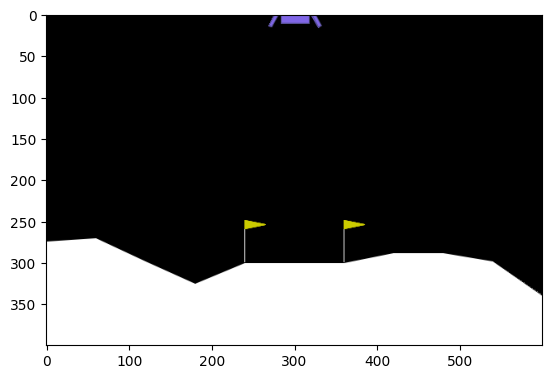

In [4]:
obs, info = env.reset()
img = env.render()
plt.imshow(img)
display()
# the coordinates of the lander in x & y, 
# its linear velocities in x & y, 
# its angle, 
# its angular velocity, 
# and two booleans that represent whether each leg is in contact with the ground or not.
print(obs)
print(info)

In [5]:
# 0: do nothing
# 1: fire left orientation engine
# 2: fire main engine
# 3: fire right orientation engine
gif_dir = Path() / 'data/lander/gifs'
observations = {}
rewards = {}
images = {}

def print_stats(file_descriptor):
    for idx, observation in enumerate(observations[file_descriptor]):
        print(f'{rewards[file_descriptor][idx]} <= {np.round(observation[:6], 2)}')

def manual_play(file_descriptor, actions: list[int]):
    file_path = gif_dir / f'{file_descriptor:04}.gif'
    if file_path.exists():
        print_stats(file_descriptor)
        return file_path
    observations[file_descriptor] = []
    rewards[file_descriptor] = []
    images[file_descriptor] = []

    for action in actions:
        obs, reward, terminated, truncated, info = env.step(action)
        obs = obs.tolist()
        reward = reward.tolist()
        images[file_descriptor].append(env.render())
        observations[file_descriptor].append(obs)
        rewards[file_descriptor].append(reward)
        if terminated or truncated:
            break
    imageio.mimsave(file_path, images[file_descriptor], format='GIF', duration=20)
    print_stats(file_descriptor)
    return file_path

In [6]:
# the coordinates of the lander in x & y
# its linear velocities in x & y
# its angle
# its angular velocity
# print(np.round(obs, 2))
# Image(manual_play(1, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
# Image(manual_play(2, [3, 3, 3, 0, 0, 0]))

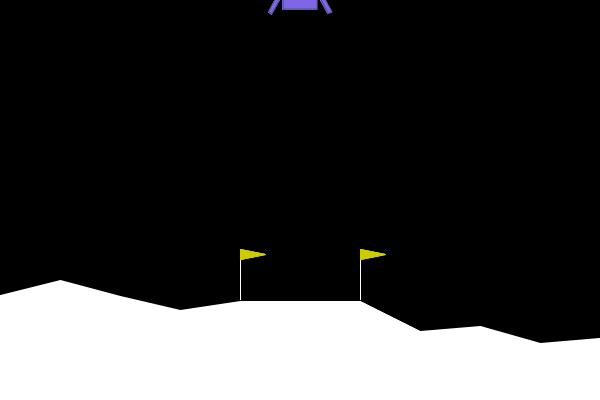

In [7]:
Image(Path() / 'data' / 'lander-001.gif')

In [8]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        action_probas = model(obs[np.newaxis])
        action_logits = tf.math.log(action_probas)
        action = tf.random.categorical(action_logits, 1)
        loss = tf.reduce_mean(loss_fn(action[0], action_probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, info = env.step(int(action))
    return obs, reward, terminated, truncated, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, terminated, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if terminated or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) 
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [9]:
def train_model(model, n_iterations, n_episodes_per_update, n_max_steps, discount_factor, folder):
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy
    mean_rewards = []
    max_reward = -9999
    for iteration in range(n_iterations):
        all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
        mean_reward = sum([sum(x) for x in all_rewards]) / n_episodes_per_update
        mean_rewards.append(mean_reward)
        print(f'Iteration: {iteration}/{n_iterations}, mean reward: {mean_reward}')
        if mean_reward > max_reward:
            model.save(folder)
            max_reward = mean_reward
            print('Saved!')
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
        all_mean_grads = []
        for var_index in range(len(model.trainable_variables)):
            # For each trainable variable, compute the weighted mean of its gradients over all episodes and all steps,
            # weighted by the final_reward. Initially, the gradients per variable reflect a step towards the action
            # actually taken. But as we introduce rewards, this can change: negative rewards will actually push 
            # it to the opposite direction of the gradient.
            mean_grads = tf.reduce_mean(
                [
                    final_reward * all_grads[episode_index][step][var_index]
                    for episode_index, final_rewards in enumerate(all_final_rewards)
                        for step, final_reward in enumerate(final_rewards)
                ], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    return mean_rewards

def train_or_load_model(model, model_folder, **kwargs):
    if Path(model_folder).exists():
        return tf.keras.models.load_model(model_folder)
    else:
        train_model(model=model, folder=model_folder, **kwargs)
        return model

In [10]:
def play_game(model, env, max_steps):
    obs, info = env.reset()
    frames = [env.render()]
    for step in range(max_steps):
        action_probas = model(obs[np.newaxis])
        action_logits = tf.math.log(action_probas) / 0.7
        action = tf.random.categorical(action_logits, 1)[0]
        obs, reward, terminated, truncated, info = env.step(int(action))
        frames.append(env.render())
        if terminated or truncated:
            break
    return frames

def create_gif(file_path, model, env, n_max_steps, override=False):
    if not override and Path(file_path).exists():
        return False
    frames = play_game(model, env, n_max_steps)
    imageio.mimsave(file_path, frames, format='GIF', duration=20)
    return True

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=[8]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# 001: Dense 5 relu; Dense 4 softmax; fully greedy
# 002: Dense 5 relu; Dense 4 softmax; with discounted future rewards 0.95
# 003: Dense 5 relu; Dense 4 softmax; with discounted future rewards 0.8
# 004: Dense 5 relu; Dense 4 softmax; with discounted future rewards 0.9
# 005: Dense 10 relu; Dense 4 softmax; with discounted future rewards 0.9
# 006: Dense 5 relu; Dense 2 softmax (with * 2 transformation in the end); with discounted future rewards 0.95
# 007: Dense 10 relu; Dense 10 relu; Dense 4 softmax; with discounted future rewards 0.92; rewards are diffed
# 008: Same as 7, number of episodes per itaration is 20, iterations=200, moved to sparse categorical crossentropy; still diffing rewards
# 009: Same as 8 without diffing rewards, now printing mean reward per iteration, 3000 max steps
# 009: Book's model; Dense 32 relu; Dense 32 relu; Dense 4 softmax

model = train_or_load_model(
    model, 
    'data/06-lunar-lander/010',
    n_iterations=200, 
    n_episodes_per_update=20, 
    n_max_steps=2000, 
    discount_factor=0.99, 
)

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                90        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 4)                 44        
                                                                 
Total params: 244 (976.00 Byte)
Trainable params: 244 (976.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model = tf.keras.models.load_model('data/06-lunar-lander/010')
create_gif('data/lander-010.gif', model, env, 3000)

True